# QVC Analysis 
 - Clustering 전처리 과정은 Jupyter 메모리상 중간에 되지를 않게 되어 .R 내용을 확인 
 - <a href="3. Clustering.R"> Clustering </a>

### 필요한 파일.
- Customer master2.csv
- order_data.csv
- product.csv
- timezone.csv
- zipcode.csv
- Product airtime.csv
- pre_order_data.csv
-  *.txt 파일

In [18]:
library(stringr)
library(arules)
library(dplyr)
library(maps)
library(ggplot2)
library(ggmap)
library(gridExtra)
library(reshape2)
library(arulesSequences)
library(lubridate)

In [19]:
theme_set(theme_gray(base_size = 13))

## Data Load

In [20]:
customer <- read.csv("data/Customer master2.csv")
customer$SHOPPER_SEGMENT_CODE <- as.factor(customer$SHOPPER_SEGMENT_CODE)

In [56]:
head(customer)

,STATE,ZIP_CODE,CUSTOMER_NBR,SHOPPER_SEGMENT_CODE,city,latitude,longitude,timezone
1,AK,99501,442649,2,Anchorage,61.216799,-149.87828,US/Alaska
2,AK,99501,657615,3,Anchorage,61.216799,-149.87828,US/Alaska
3,AK,99501,315353,1,Anchorage,61.216799,-149.87828,US/Alaska
4,AK,99501,235837,2,Anchorage,61.216799,-149.87828,US/Alaska
5,AK,99502,516194,3,Anchorage,61.153693,-149.95932,US/Alaska
6,AK,99502,224909,0,Anchorage,61.153693,-149.95932,US/Alaska


In [21]:
order_df <- read.csv("data/order_data.csv", stringsAsFactors = F)
order_df$SHOPPER_SEGMENT_CODE[is.na(order_df$SHOPPER_SEGMENT_CODE)] <- 0
order_df$SHOPPER_SEGMENT_CODE <- as.factor(order_df$SHOPPER_SEGMENT_CODE)

In [60]:
unique(order_df$timezone)

[1] "EST5EDT"   "CST6CDT"   "PST8PDT"   "MST7MDT"   "US/Alaska" "MST"      
[7] "US/Hawaii"

In [22]:
zip <- read.csv("data/zipcode.csv", stringsAsFactors = F)

# Data 확인. 

## 1. 고객 분포도. Zip Code 별 고객 분포도.

In [23]:
v_customer <- customer %>% group_by(ZIP_CODE) %>% summarize(cnt = n()) %>% filter(cnt > 5)
v_customer <- merge(v_customer,zip[,c(1,3:5)],by.x="ZIP_CODE",by.y="zip")

In [24]:
head(v_customer)

,ZIP_CODE,cnt,state,latitude,longitude
1,1001,8,MA,42.07061,-72.62029
2,1007,6,MA,42.278424,-72.411
3,1013,9,MA,42.161492,-72.60316
4,1020,9,MA,42.175992,-72.57265
5,1027,6,MA,42.27279,-72.68677
6,1028,8,MA,42.066795,-72.5102


### 지도 그리기

In [25]:
options(repr.plot.width=5, repr.plot.height=5)

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=united+states&zoom=4&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=united%20states&sensor=false


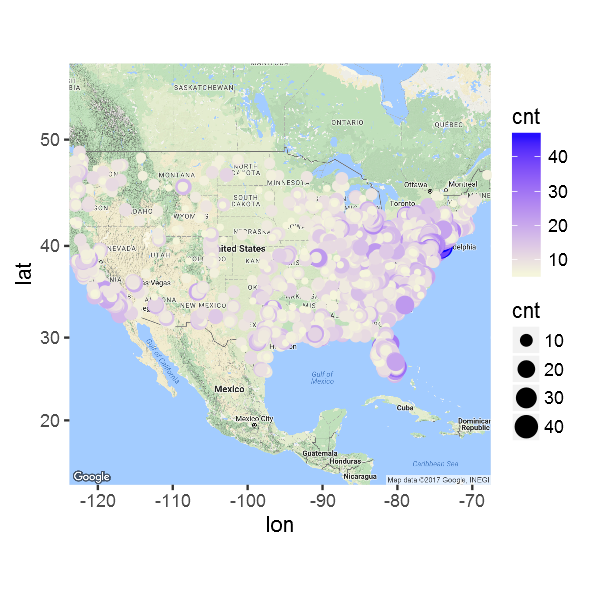

In [26]:
map<-get_map(location='united states', zoom=4, maptype = "terrain",
             source='google',color='color')

ggmap(map) + geom_point(
  aes(x=longitude, y=latitude, show_guide = TRUE, colour=cnt, size=cnt),
  data=v_customer, alpha=1,na.rm = T)  +
  scale_color_gradient(low="beige", high="blue")

### 지도그리기 2 

In [27]:
options(repr.plot.width=5, repr.plot.height=3)

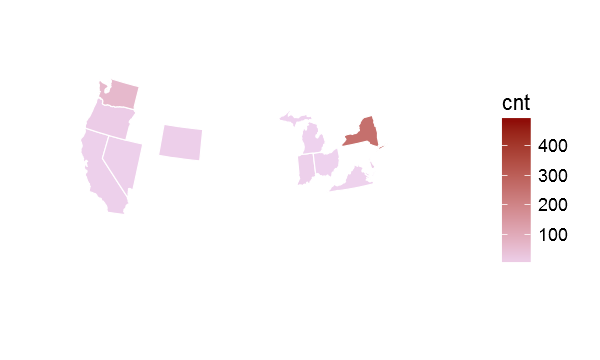

In [28]:
us <- map_data("state")
city <- customer %>% group_by(city) %>% summarize(cnt = n())
city <- city %>% mutate(avg = cnt/mean(cnt))
city$city <- tolower(city$city)

gg <- ggplot()
gg <- gg + geom_map(data=us, map=us,
                    aes(x=long, y=lat, map_id=region),
                    fill="#ffffff", color="#ffffff", size=0.25)

gg <- gg + geom_map(data=city, map=us,
                    aes(fill=cnt, map_id=city),
                    color="#ffffff", size=0.25)
gg <- gg + scale_fill_continuous(low='thistle2', high='darkred', 
                                 guide='colorbar')
gg <- gg + labs(x=NULL, y=NULL)
gg <- gg + coord_map("albers", lat0 = 39, lat1 = 45) 
gg <- gg + theme(panel.border = element_blank())
gg <- gg + theme(panel.background = element_blank())
gg <- gg + theme(axis.ticks = element_blank())
gg <- gg + theme(axis.text = element_blank())
gg

## timezone 별 고객 분포도

In [29]:
options(repr.plot.width=7, repr.plot.height=3)

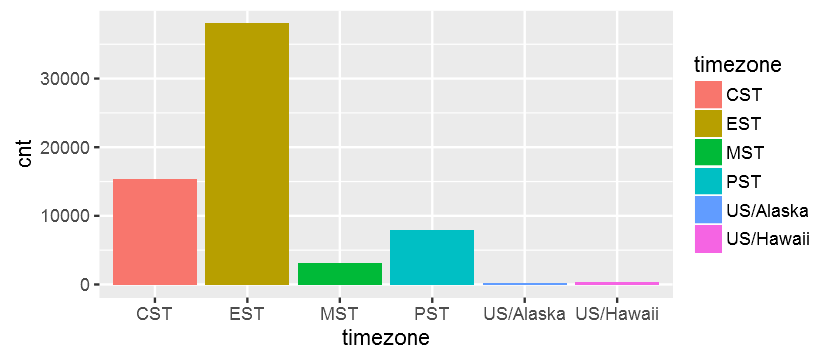

In [30]:
timezone_customer <- customer %>% group_by(timezone) %>% summarize(cnt=n())
ggplot(timezone_customer,aes(x=timezone,y=cnt,fill=timezone)) + geom_bar(stat="identity")

## 2. State 별 고객 분포

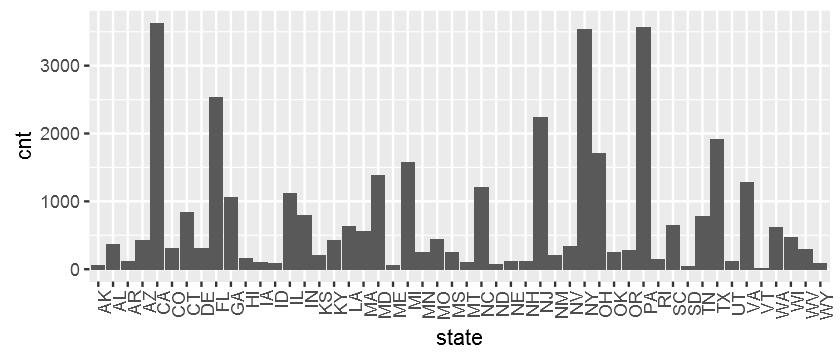

In [31]:
state_number <- v_customer %>% group_by(state) %>% summarize(cnt = sum(cnt)) %>% arrange(desc(cnt))
ggplot(v_customer, aes(x=state,y=cnt)) + geom_bar(stat="identity") + theme(axis.text.x = element_text(angle = 90, hjust = 1))

## 3. State 별 Segment 별 고객 분포

In [32]:
customer$SHOPPER_SEGMENT_CODE[is.na(customer$SHOPPER_SEGMENT_CODE)] <- 0
customer$SHOPPER_SEGMENT_CODE <- factor(customer$SHOPPER_SEGMENT_CODE)
seg_customer <- customer

In [33]:
names(seg_customer)[4] <- "CODE"

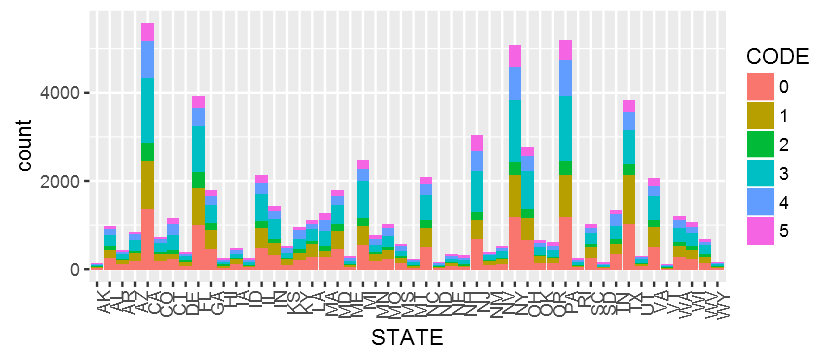

In [34]:
ggplot(seg_customer,aes(x=STATE,fill=CODE)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

## 4. segment 별 고객 분포

In [35]:
segment_customer <- customer %>% group_by(SHOPPER_SEGMENT_CODE) %>% summarize(cu_cnt = n()) %>% mutate(prob = round((cu_cnt/sum(cu_cnt)),2)*100)
segment_customer$SHOPPER_SEGMENT_CODE[is.na(segment_customer$SHOPPER_SEGMENT_CODE)] <- 0

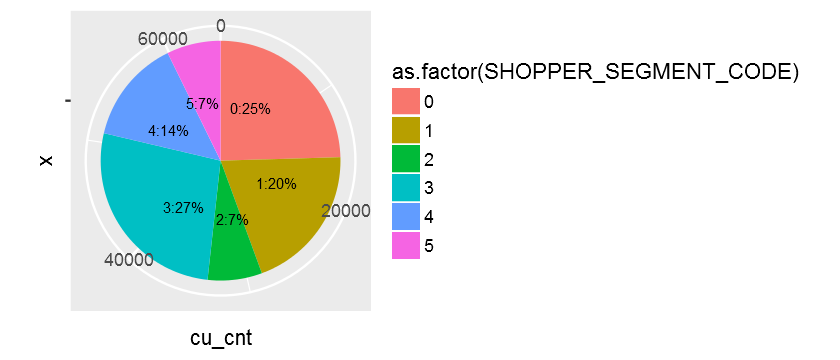

In [37]:
bp<- ggplot(segment_customer, aes(x="", y=cu_cnt, fill=as.factor(SHOPPER_SEGMENT_CODE)))+
  geom_bar(width = 1, stat = "identity") 
pie <- bp + coord_polar("y", start=0)
# scale_fill_brewer("Blues") + blank_theme +
pie + 
  #theme(axis.text.x=element_blank())+
  geom_text(aes(y = cu_cnt/3 + c(0, cumsum(cu_cnt)[-length(cu_cnt)]), 
                label = paste0(SHOPPER_SEGMENT_CODE,":",prob,"%")), size=3)

## 5. segment 별 구매 횟수 

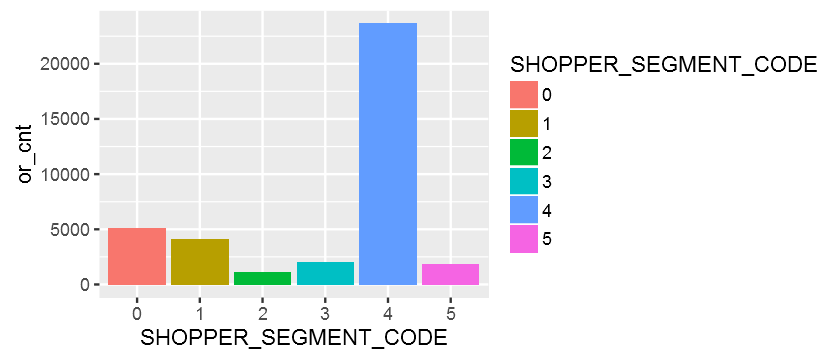

In [40]:
segment_order <- order_df %>% group_by(SHOPPER_SEGMENT_CODE) %>% summarize(or_cnt=n())
segment_order$percent <- round(prop.table(segment_order$or_cnt),2) 

ggplot(segment_order,aes(x=SHOPPER_SEGMENT_CODE,y=or_cnt,fill=SHOPPER_SEGMENT_CODE)) + geom_bar(stat="identity")

## 5.1 segment 별 회원수 

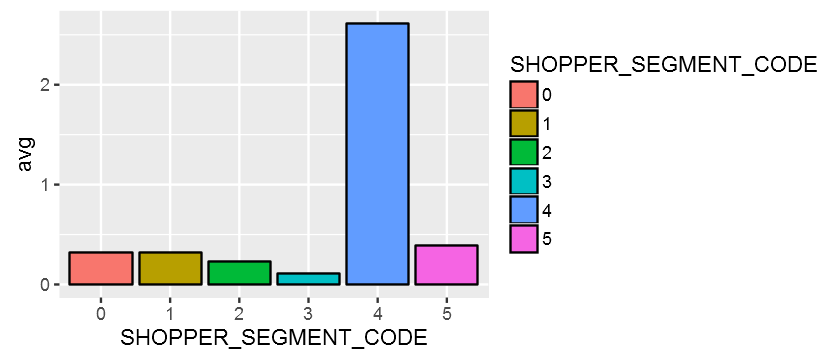

In [41]:
segment_cus_order <- order_df %>% distinct(CUSTOMER_NBR,SHOPPER_SEGMENT_CODE) %>% group_by(SHOPPER_SEGMENT_CODE) %>% summarize(or_cnt=n())
 # 합쳐서
seg <- merge(segment_customer,segment_order,by="SHOPPER_SEGMENT_CODE")
seg <- seg %>% mutate(avg = round(or_cnt/cu_cnt,2))
ggplot(seg,aes(x=SHOPPER_SEGMENT_CODE,y=avg,fill=SHOPPER_SEGMENT_CODE)) + geom_bar(stat="identity",colour="black")

## 5.2  월별 판매 수

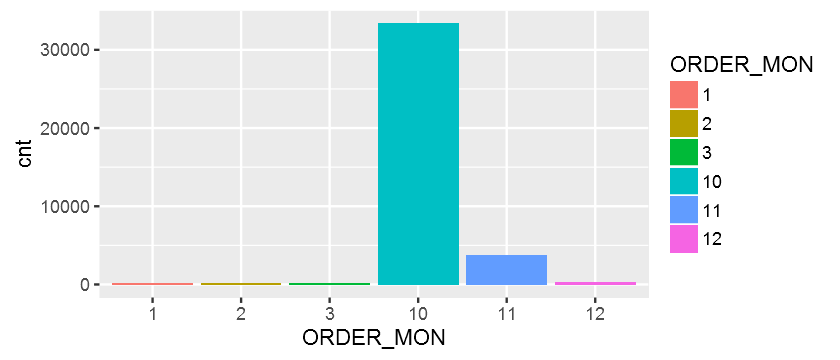

In [42]:
#  월별 판매 수
mon_order <- order_df %>% group_by(ORDER_MON) %>% summarize(cnt =n())
mon_order$ORDER_MON <- as.factor(mon_order$ORDER_MON)
mon_order$per <- round(prop.table(mon_order$cnt),2) * 100
ggplot(data=mon_order,aes(x=ORDER_MON,y=cnt,fill=ORDER_MON)) +geom_bar(stat="identity")

## 6. 요일별 주문 Count ####

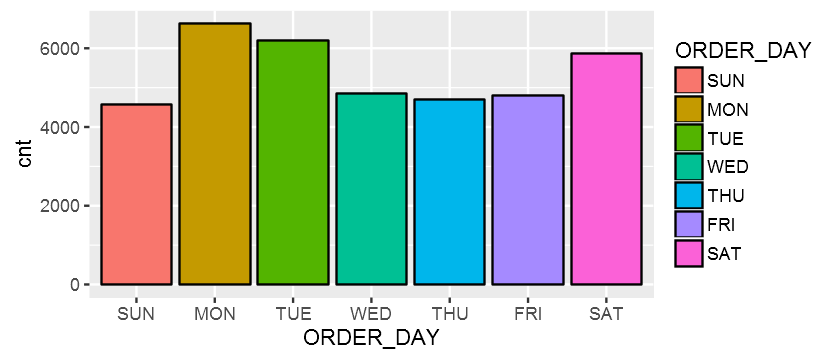

In [43]:
v_day <- order_df %>% group_by(ORDER_DAY) %>% summarize(cnt=n())
v_day$ORDER_DAY = factor(v_day$ORDER_DAY,labels=c("SUN","MON","TUE","WED","THU","FRI","SAT"),ordered=TRUE)
ggplot(v_day, aes(x=ORDER_DAY,y=cnt,fill=ORDER_DAY)) + geom_bar(stat="identity",colour="black")

## 7. 카테고리별 구매 횟수 5개 ####

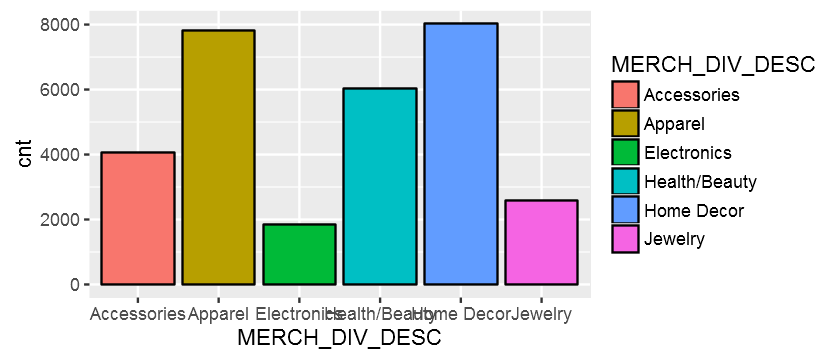

In [44]:
order_per_cate <- order_df %>% group_by(MERCH_DIV_DESC) %>% summarize(cnt = n()) %>% arrange(desc(cnt))
ggplot(head(order_per_cate), aes(x=MERCH_DIV_DESC,y=cnt,fill=MERCH_DIV_DESC)) + geom_bar(stat="identity",colour="black")

## 8. 가장 많이 팔린 제품 상위 5개 ####

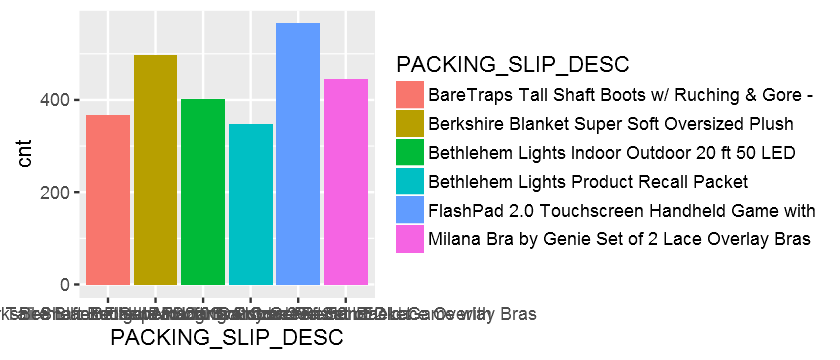

In [46]:
order_per_product <- order_df %>% group_by(PACKING_SLIP_DESC) %>% summarize(cnt = n()) %>% arrange(desc(cnt))
ggplot(head(order_per_product), aes(x=PACKING_SLIP_DESC,y=cnt,fill=PACKING_SLIP_DESC)) + geom_bar(stat="identity")

## 9. 시간대별 판매 수 ####

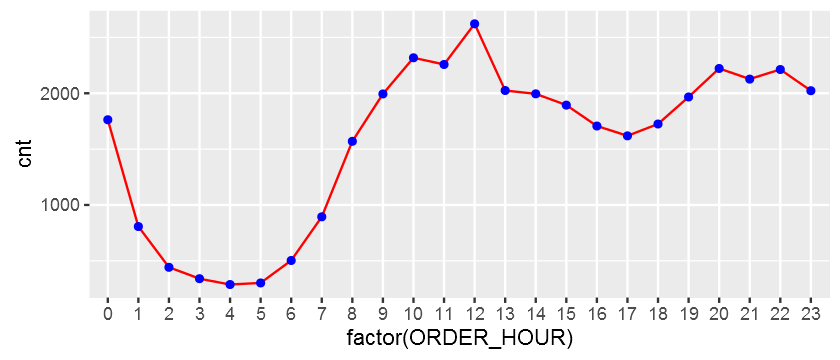

In [48]:
v_time_cate <- order_df %>% group_by(ORDER_HOUR,MERCH_DIV_DESC) %>% summarize(cnt = n()) # 다른 데서 line plot으로 시간대별로 다르게 표현.
time_order <- v_time_cate %>% group_by(ORDER_HOUR) %>% summarize(cnt = sum(cnt))
ggplot(data=time_order, aes(x=factor(ORDER_HOUR), y=cnt,group=1)) + geom_line(color="red") + geom_point(color="blue")

## 10. Timezone 별 주문 횟수 ####

In [58]:
timezone_order <- order_df %>% group_by(timezone) %>% summarize(cnt = n()) %>% mutate(prob = round((cnt/sum(cnt)),3)*100)
timezone_order

,timezone,cnt,prob
1,CST6CDT,8791,23.4
2,EST5EDT,21504,57.2
3,MST,396,1.1
4,MST7MDT,1493,4
5,PST8PDT,5201,13.8
6,US/Alaska,151,0.4
7,US/Hawaii,82,0.2


# Answer the Questions 

## 1. What is the next product a customer will buy in the next month given their previous buying behavior and product airtime?
 - 제품의 경우 같은 Cluster 내 고객들의 구매 내역 중 내가 사지 않은 내역을 추천

In [62]:
order_df <- read.csv("data/order_data_cluster.csv", stringsAsFactors = F)
customer <- read.csv("data/customer_with_cluster.csv",stringsAsFactors = F)

In [63]:
for(i in 1:9){
  tmp_df <- order_df %>% filter(cluster==i)
  assign(paste0("cluster_",i),tmp_df)
}

In [64]:
for(i in 1:9){
  tmp_df <- get(paste0("cluster_",i))
  tmp_df <- tmp_df %>% group_by(CUSTOMER_NBR,MERCH_DIV_DESC) %>% summarize(cnt = n()) %>% arrange(CUSTOMER_NBR)
  assign(paste0("cluster_cate_",i),as.data.frame(tmp_df))
}

In [65]:
for(i in 1:9){
  tmp_df <- get(paste0("cluster_",i))
  tmp_df <- tmp_df %>% group_by(CUSTOMER_NBR,PRODUCT_ID) %>% summarize(cnt = n()) %>% arrange(CUSTOMER_NBR)
  assign(paste0("cluster_product_",i),as.data.frame(tmp_df))
}

### id별로 추천 가져오는 Function ####
### 1. Product 별 

In [92]:
getProductRecommand <- function(x){
  custId <- x
  custCluster <- customer[customer$CUSTOMER_NBR==custId,]$cluster
  in_df <- get(paste0("cluster_product_",custCluster))
  in_product_list <- in_df[in_df$CUSTOMER_NBR==custId,]$PRODUCT_ID
  in_product_list <- as.data.frame(in_product_list)
  other_df <- in_df %>% filter(CUSTOMER_NBR!=custId) %>% group_by(PRODUCT_ID) %>% summarize(cnt = sum(cnt)) %>% arrange(desc(cnt))
  other_df <- as.data.frame(other_df)
  other_df$percent <- round(prop.table(other_df$cnt),2)  
  result_df <- other_df %>% filter(!(PRODUCT_ID %in% in_product_list$in_producut_list))
  result_df <- left_join(result_df,product)
  names(in_product_list)[1] <- "PRODUCT_ID"
  in_product_list <- left_join(in_product_list,product)
  print(in_product_list[,c(1,2)])
  print(head(result_df[,c(1,4,2,3)]))
}

## 2. In what product category is a customer likely to buy their next product, given their previous buying behavior and product airtime? 
 - 카테고리의 경우 같은 카테고리를 구매할 가능성이 높으므로 연관분석을 통해 추천 

### 2. Category

In [93]:
getCateRecommand <- function(x){
  custId <- x
  custCluster <- customer[customer$CUSTOMER_NBR==custId,]$cluster
  if(length(custCluster)==0){
    return(0)
  }
  baskets <-  read_baskets(con  = paste0("data/item_cate_",custCluster,".txt"),sep = "#", info = c("sequenceID","eventID","SIZE"))
  baskets <- cspade(baskets, parameter = list(support = 0.0001), control = list(verbose = TRUE))
  baskets_df <- as(baskets, "data.frame")
  baskets_df <- baskets_df[order(baskets_df$support,decreasing = T),]
  baskets_df$sequence <- gsub(pattern = "<\\{\"","",baskets_df$sequence)
  baskets_df$sequence <- gsub(pattern = "\"\\}>","",baskets_df$sequence)
  baskets_df$sequence <- gsub(pattern = "\"","",baskets_df$sequence)
  last_df <- order_df[order_df$CUSTOMER_NBR==custId,] %>% 
    arrange(desc(ORDER_DATES)) %>% 
    select(MERCH_DIV_DESC)
  last_cate <- last_df$MERCH_DIV_DESC
  support_df <- baskets_df %>% filter(str_detect(sequence,last_cate))
  print(paste0(last_cate))
  print(head(support_df[-1,]))
}

In [94]:
getRecommand <- function(cate,y){
  if(cate=="cate"){
    getCateRecommand(y)
  }else{
    getProductRecommand(y)
  }
}

In [95]:
getRecommand("cate",1275)


parameter specification:
support : 1e-04
maxsize :    10
maxlen  :    10

algorithmic control:
bfstype  : FALSE
verbose  :  TRUE
summary  : FALSE
tidLists : FALSE

preprocessing ... 1 partition(s), 0.09 MB [0.17s]
mining transactions ... 0 MB [0.14s]
reading sequences ... [0.07s]

total elapsed time: 0.38s
[1] "Entertainment" "Health/Beauty" "Health/Beauty" "Health/Beauty"
[5] "Health/Beauty" "Health/Beauty"
                       sequence      support
2      Health/Beauty,Home Decor 0.0032706460
3 Health/Beauty,IQVC Divisional 0.0029980921
4         Health/Beauty,Apparel 0.0027255383
5     Accessories,Health/Beauty 0.0010902153
6         Health/Beauty,Jewelry 0.0008176615
7      Health/Beauty,Housewares 0.0008176615


In [103]:
getRecommand("product",749351)

ERROR: Error in tbl_vars(y): object 'product' not found
